In [5]:
import numpy as np
from scipy import sparse
import seaborn
import time

In [6]:
long_house = [18, 78]
sub_house = [12, 18]
square_house = [18, 18]

def place_houses(offset, direction):
    if direction == 'forward':
      return list(
        map(
          tuple,
          [offset + long_house, list(np.array(offset) + [18, 0]) + sub_house, 
          list((np.array(offset) + [0, 99])) + square_house,
          list(np.array(offset) + [0, 153]) + long_house,
          list(np.array(offset) + [18, 153]) + sub_house,
          list(np.array(offset) + [0, 252]) + square_house]
        )
      )
    elif direction == 'reverse':
      return list(
        map(
          tuple,
          [offset + square_house, list(np.array(offset) + [0, 39]) + long_house,
          list(np.array(offset) + [-12, 99]) + sub_house,
          list(np.array(offset) + [0, 153]) + square_house,
          list(np.array(offset) + [0, 192]) + long_house,
          list(np.array(offset) + [-12, 252]) + sub_house]
        )
      )
  

In [7]:
def solve(n_iter=5000000, eps=1e-5, M=300):
  def in_house(x, y):
    for x0, y0, w, h in houses:
      if x0 <= x < x0 + w and y0 <= y < y0 + h:
        return True
    return False
  lambda1 = 1.0
  lambda2 = 0

  houses = place_houses([69, 12], 'forward') + place_houses([138, 12], 'reverse') + \
    place_houses([192, 12], 'forward') + place_houses([261, 12], 'reverse')

  houses = list(
    map(
      lambda ftuple: list(
        map(
          lambda x: round(x * M / 300), ftuple)
        ),
        houses
      )
    )

  K = 0.5
  h = 1 / M
  tau = h * h / (4 * K)

  MM = M * M
  
  xs = np.zeros(MM)
  for i in range(M):
    xs[i] = 1
    
  A = sparse.lil_matrix((MM, MM))
  
  f = np.zeros(MM)
    
  dcol = [0, 1, -1, 0, 0]
  drow = [0, 0, 0, 1, -1]
  coeffs = [1 - 4 * (tau * K) / (h * h),
            tau * (K / (h * h) - lambda1 / (2 * h)),
            tau * (K / (h * h) + lambda1 / (2 * h)),
            tau * (K / (h * h) - lambda2 / (2 * h)),
            tau * (K / (h * h) + lambda2 / (2 * h))]

  for col in range(M): 
      for row in range(M):
          ind = col * M + row

          if col == 0:
            A[ind, ind] = 1
            continue
          
          A[ind, ind] = coeffs[0]
          for i in range(1, 5):
              ncol = col + dcol[i]
              nrow = row + drow[i]
              coeff = coeffs[i]

              if ncol <= 0:
                  f[ind] += coeff
              elif in_house(ncol, nrow) or nrow >= M - 1 or ncol >= M - 1 or nrow <= 0:
                  A[ind, ind] += coeff
              else:
                  A[ind, ncol * M + nrow] = coeff

  A = sparse.csr_matrix(A)

  start = time.time()

  for iter in range(n_iter):
    xs_new = A @ xs + f
    error = np.max(np.abs(xs_new - xs))
    if error < eps:
        print('Number of steps taken: {}'.format(iter))
        print('Time taken: {} sec'.format(round(time.time() - start), 4))
        break
    xs = xs_new
  return xs.reshape((M, M)).T[::-1]


Number of steps taken: 4047
Time taken: 3 sec


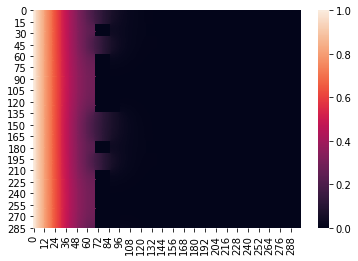

In [8]:
u = solve(eps=10e-5)
seaborn.heatmap(u)

Number of steps taken: 36180
Time taken: 25 sec


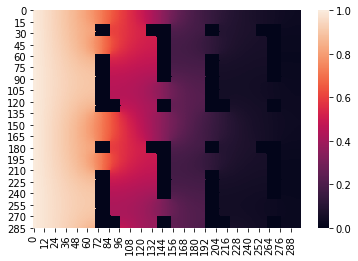

In [9]:
u = solve(eps=10e-6)
seaborn.heatmap(u)

Number of steps taken: 305765
Time taken: 289 sec


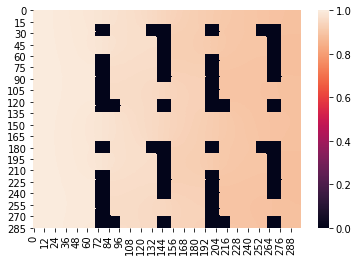

In [10]:
u = solve(eps=10e-7)
seaborn.heatmap(u)